In [5]:
import sys
import tensorflow as tf
#added
tf.compat.v1.keras.utils.track_tf1_style_variables 
tf.compat.v1.disable_eager_execution()


#
import numpy as np
sys.path.insert(0, './scripts')
from tqdm import tqdm
import feature_tools as ft

#init params
NN_MODEL = 'lang2vec'
INPUT_DIM = 40
is_batchnorm = False
SOFTMAX_NUM = 17
nn_model = __import__(NN_MODEL)
FEAT_TYPE='mfcc'
N_FFT=400
HOP=160
VAD=True
CMVN='m'
DATA_ROOT='/your_own_folder'


#init placeholder
test_feat_batch = tf.compat.v1.placeholder(tf.float32, [None,None,np.int(INPUT_DIM)],name="test_feat_batch")
test_label_batch = tf.compat.v1.placeholder(tf.int32, [None],name="test_label_batch")
test_shape_batch = tf.compat.v1.placeholder(tf.int32, [None,2],name="test_shape_batch")

#init model
emnet_validation = nn_model.nn(test_feat_batch,test_label_batch,test_label_batch,test_shape_batch, SOFTMAX_NUM,False,INPUT_DIM,is_batchnorm);
tf.compat.v1.get_variable_scope().reuse_variables()
sess = tf.compat.v1.InteractiveSession()
saver = tf.compat.v1.train.Saver()
tf.compat.v1.global_variables_initializer().run()

#load pretrained model
RESUME_STARTPOINT = 7712000
saver.restore(sess,'data/pretrained_model/model'+str(RESUME_STARTPOINT)+'.ckpt-'+str(RESUME_STARTPOINT))

/var/folders/g7/9btfkc0s1_vbzyx4w948nhrw0000gn/T/ipykernel_85698/3493276684.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_feat_batch = tf.compat.v1.placeholder(tf.float32, [None,None,np.int(INPUT_DIM)],name="test_feat_batch")
2022-05-09 10:02:39.691404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 10:02:39.691753: I tensorflow/core/common_runtime/pluggable_device/pl

Tensor("softmax_1/transpose:0", shape=(None, None, 1000), dtype=float32)
Tensor("softmax_1/transpose_1:0", shape=(None, None, 1000), dtype=float32)
Tensor("softmax_1/transpose_2:0", shape=(None, None, 1000), dtype=float32)
Tensor("softmax_1/transpose_3:0", shape=(None, None, 1500), dtype=float32)
Tensor("softmax_1/Mul:0", shape=(None, None, 1000), dtype=float32)
(None, 3000)
(None, 1500)
(None, 600)
INFO:tensorflow:Restoring parameters from data/pretrained_model/model7712000.ckpt-7712000


In [8]:
wav_list = ['./dev_segments/6Uhm_-qTBj4_107433-108167.wav']

#feature extraction
feat, _, utt_shape, tffilename = ft.feat_extract(wav_list,FEAT_TYPE,N_FFT,HOP,VAD,CMVN,0)

#extract output layer
output = []
for iter in tqdm(range(len(feat))):
    o1 = emnet_validation.o1.eval({test_feat_batch:[feat[iter]], test_shape_batch:[utt_shape[iter]]})
    output.extend([o1])
output = np.squeeze(output)

print (output)

  0%|                                                     | 0/1 [00:00<?, ?it/s]/Users/mac/Desktop/Master_topic/arabic_dialect_identification_v2/./scripts/feature_tools.py:57: FutureWarning: Pass y=[ 0.00683594  0.00744629  0.00585938 ...  0.00079346 -0.00137329
 -0.00253296], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  Y = librosa.feature.mfcc(y,sr,n_fft=n_fft_length,hop_length=hop,n_mfcc=40,fmin=133,fmax=6955)
/Users/mac/Desktop/Master_topic/arabic_dialect_identification_v2/./scripts/feature_tools.py:77: FutureWarning: Pass y=[ 0.00683594  0.00744629  0.00585938 ...  0.00079346 -0.00137329
 -0.00253296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  E = librosa.feature.rms(y, frame_length=n_fft_length,hop_length=hop,)
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]

[-0.80319107 11.656134   -3.9971428   5.005442   -0.13741374  0.11655271
  0.5420608   1.3633422   0.2572124   0.5312619  -2.0948212   0.82006687
 -3.0744617  -6.930929    4.9400926   2.6363657  -2.8165    ]


Text(0.5, 1.0, 'Dialect identification offline test result')

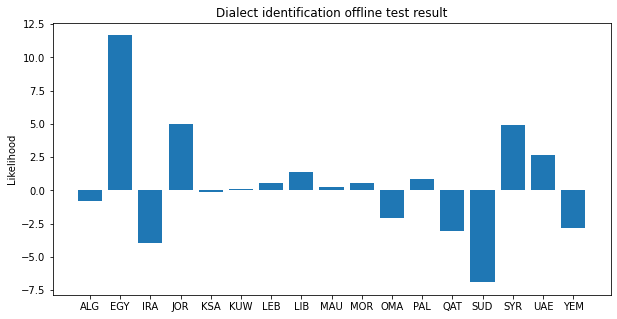

In [9]:
dialects = []
for line in open('data/language_id_initial').readlines():
    dialects.append(line.rstrip().split()[0])

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline

x = np.arange(17)
plt.figure(figsize=(10, 5))
plt.bar(x,output,align='center')
plt.xticks(x,dialects)
plt.ylabel('Likelihood')
plt.title('Dialect identification offline test result')